# Práctica Transfer Learning para clasificación de imágenes

En esta práctica, explorarás el concepto de Transfer Learning utilizando el
dataset CIFAR-10. Implementarás modelos con tres arquitecturas diferentes
preentrenadas, comparando su rendimiento, con el objetivo de aprender a
aprovechar modelos preentrenados para resolver problemas de clasificación.

## Descripción del dataset a utilizar

El dataset CIFAR-10 contiene 60,000 imágenes de 32x32 píxeles distribuidas en
10 clases (por ejemplo, aviones, automóviles, pájaros, gatos, etc.). Este dataset
es adecuado para tareas de clasificación de imágenes y es ampliamente utilizado
en la investigación de visión por computadora.

## Parte 1: Preparación
1. Carga del dataset: Utiliza la función load_data() para cargar el dataset
CIFAR-10 (la función está en tensorflow.keras.datasets.cifar10).<br><br>
2. Preprocesamiento de Datos: normaliza las imágenes (escalar los
valores de píxeles entre 0 y 1) y convierte las etiquetas a formato one-hot.

In [25]:
# Genearl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Tensorflow y Keras
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
(train_X,train_Y), (test_X,test_Y) = tf.keras.datasets.cifar10.load_data()

In [27]:
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [28]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [3]')

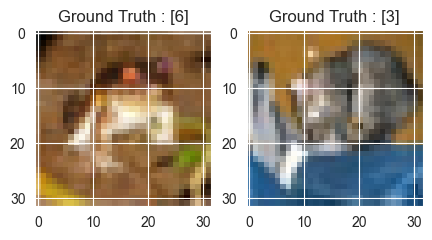

In [29]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))


In [30]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [31]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: [6]
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [32]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [33]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10))

## Parte 2: Implementación y entrenamiento
1. Arquitecturas: utilizaremos VGG16, ResNet50 e InceptionV3. <br><br>
2. Preparación de las arquitecturas: carga cada uno de los modelos
preentrenados sin las capas superiores (sin la capa de clasificación) y
congela todas las capas. <br><br>
3. Construcción: <br><br>
o VGG16: Usa VGG16 preentrenado en imagenes de ImageNet. <br><br>
o ResNet50: Usa ResNet50 preentrenado. <br><br>
o InceptionV3: Usa InceptionV3 preentrenado. <br><br>
4. Compilación: Utiliza el optimizador Adam y la función de pérdida
categorical_crossentropy. <br><br>
5. Entrenamiento: entrena cada modelo con las imágenes del conjunto de
entrenamiento y evalúa en el conjunto de test. Ajusta el número de épocas
según sea necesario.


In [34]:
# Cargar VGG16 sin la capa de clasificación final
base_model_VGG16 = VGG16(weights='imagenet', include_top=False,
input_shape=(75, 75, 3))
# Congelar las capas convolucionales
for layer in base_model_VGG16.layers:
 layer.trainable = False
# Agregar capas densas personalizadas
x = Flatten()(base_model_VGG16.output)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Para clasificación binaria
# Crear el modelo final y compilar
model = Model(inputs=base_model_VGG16.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001),
loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 75, 75, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,489 (58.13 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
# Cargar VGG16 sin la capa de clasificación final
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False,
input_shape=(75, 75, 3))
# Congelar las capas convolucionales
for layer in base_model_ResNet50.layers:
 layer.trainable = False
# Agregar capas densas personalizadas
x = Flatten()(base_model_ResNet50.output)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Para clasificación binaria
# Crear el modelo final y compilar
model = Model(inputs=base_model_ResNet50.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001),
loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 81, 81, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 38, 38,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 38, 38,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 38, 38,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 40, 40,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 19, 19,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 19, 19,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 19, 19,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 19, 19,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 19, 19,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 19, 19,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 19, 19,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 19, 19,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 19, 19,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 19, 19,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 19, 19,    │      1,024 │ conv2_block1_3_c

 Total params: 28,306,817 (107.98 MB)

 Trainable params: 4,719,105 (18.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [36]:
# Cargar VGG16 sin la capa de clasificación final
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False,
input_shape=(75, 75, 3))
# Congelar las capas convolucionales
for layer in base_model_InceptionV3.layers:
 layer.trainable = False
# Agregar capas densas personalizadas
x = Flatten()(base_model_InceptionV3.output)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Para clasificación binaria
# Crear el modelo final y compilar
model = Model(inputs=base_model_InceptionV3.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001),
loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 37, 37,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 35, 35,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 35, 35,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 17, 17,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 17, 17,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 15, 15,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Descongelar algunas capas superiores
for layer in base_model_VGG16.layers[-4:]: # Descongelar 4 últimas capas
 layer.trainable = True
# Compilar nuevamente con una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=0.00001),
loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Descongelar algunas capas superiores
for layer in base_model_ResNet50.layers[-4:]: # Descongelar 4 últimas capas
 layer.trainable = True
# Compilar nuevamente con una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=0.00001),
loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Descongelar algunas capas superiores
for layer in base_model_InceptionV3.layers[-4:]: # Descongelar 4 últimas capas
 layer.trainable = True
# Compilar nuevamente con una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=0.00001),
loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

batch_size = 32
epochs = 20
num_classes = 10
base_model_VGG16 = base_model_VGG16.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

## Parte 3: Evaluación
1. Obtención de métricas: evalúa los tres modelos utilizando el conjunto de
prueba y compara su precisión. Genera las gráficas de pérdida y
precisión, así como la matriz de confusión y el informe de clasificación.<br><br>
2. Comparación de resultados: compara las métricas de precisión de los
tres modelos. ¿Cuál de los modelos tiene mejor rendimiento? ¿Por qué
crees que ocurre esto? ¿Cómo afecta la arquitectura del modelo
preentrenado al rendimiento en el dataset CIFAR-10? ¿Crees que el
modelo con más parámetros siempre es el mejor? Justifica tu respuesta

In [ ]:
test_eval = base_model_VGG16.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


In [ ]:
test_eval = base_model_ResNet50.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


In [ ]:
test_eval = base_model_InceptionV3.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


In [ ]:
accuracy = base_model_VGG16.history['accuracy']
val_accuracy = base_model_VGG16.history['val_accuracy']
loss = base_model_VGG16.history['loss']
val_loss = base_model_VGG16.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
accuracy = base_model_ResNet50.history['accuracy']
val_accuracy = base_model_ResNet50.history['val_accuracy']
loss = base_model_ResNet50.history['loss']
val_loss = base_model_ResNet50.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
accuracy = base_model_InceptionV3.history['accuracy']
val_accuracy = base_model_InceptionV3.history['val_accuracy']
loss = base_model_InceptionV3.history['loss']
val_loss = base_model_InceptionV3.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

In [ ]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(test_Y, predicted_classes)

# Etiquetas correctas para las 10 clases
labels = ["Class {}".format(i) for i in range(num_classes)]

# Mostrar matriz de confusión con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()